In [21]:
from sklearn.preprocessing import LabelEncoder
import nltk
import demoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import unicodedata as uni
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


from tqdm import tqdm
tqdm.pandas()

In [22]:
sentfin = pd.read_csv('dataset/SEntFiN-v1.1.csv', encoding="latin-1")
sentfin.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [23]:
def preprocess(text):
    # Text normalization
    contractions = {
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "won't": "will not",
        "wouldn't": "would not",
        "don't": "do not",
        "doesn't": "does not",
        "didn't": "did not",
        "can't": "can not",
        "couldn't": "could not",
        "shouldn't": "should not",
        "mightn't": "might not",
        "mustn't": "must not",
        "I'm": "I am",
        "You're": "you are",
        "I've": "I have",
        "UI": "user interface",
        "UX": "user experience",
        "u": "you",
    }
    pattern = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b')
    expanded_text = pattern.sub(lambda match: contractions[match.group(0)], text)

    normalized_text = uni.normalize('NFKD', expanded_text)
    normalized_text = ''.join([c for c in normalized_text if not uni.combining(c)])

    # emoji encoding
    emojis = demoji.findall(text)

    for emoji in emojis:
        text = text.replace(emoji, " " + emojis[emoji].split(":")[0])

    # text preprocessing
    teks = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    teks = teks.lower()
    stop_words = set(stopwords.words('english'))
    stop_words.update(['also', 'app', 'apps', 'application', 'applications', 'good'])
    stop_words.remove('not')
    tokens = word_tokenize(teks)
    filtered_tokens = [word for word in tokens if word.isalnum() and not any(char.isdigit() for char in word) and word not in stop_words]
    lemmatizer = nltk.WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    clean_reviews = ' '.join(lemma)

    return clean_reviews

In [24]:
sentfin['text'] = sentfin.Title.progress_apply(preprocess)

100%|██████████| 10753/10753 [00:05<00:00, 2007.03it/s]


In [25]:
import ast
# Mengonversi string JSON ke dictionary
sentfin['Decisions'] = sentfin['Decisions'].apply(ast.literal_eval)
# Ekstrak teks dan label
sentfin['label'] = sentfin['Decisions'].apply(lambda x: list(x.values())[0])
# Encode label
le = LabelEncoder()
sentfin['label'] = le.fit_transform(sentfin['label'])
sentfin

,S No.,Title,Decisions,Words,text,label
0,1,SpiceJet to issue 6.4 crore warrants to promoters,{'SpiceJet': 'neutral'},8,spicejet issue crore warrant promoter,1
1,2,MMTC Q2 net loss at Rs 10.4 crore,{'MMTC': 'neutral'},8,mmtc net loss r crore,1
2,3,"Mid-cap funds can deliver more, stay put: Experts",{'Mid-cap funds': 'positive'},8,midcap fund deliver stay put expert,2
3,4,Mid caps now turn into market darlings,{'Mid caps': 'positive'},7,mid cap turn market darling,2
4,5,"Market seeing patience, if not conviction: Pra...",{'Market': 'neutral'},8,market seeing patience not conviction prakash ...,1
...,...,...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{'Chambal': 'negative', 'Advanta': 'negative'}",6,negative chambal advanta mitesh thacker,0
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{'Small': 'positive', 'Mid-cap stocks': 'posit...",6,small midcap stock may emerge outperformers,2
10750,10751,Rupee slips against US dollar,"{'Rupee': 'negative', 'US dollar': 'neutral'}",5,rupee slip u dollar,0
10751,10752,Rupee weak against US dollar,"{'Rupee': 'negative', 'US dollar': 'neutral'}",5,rupee weak u dollar,0


In [28]:
df = sentfin[['text', 'label']]
df

,text,label
0,spicejet issue crore warrant promoter,1
1,mmtc net loss r crore,1
2,midcap fund deliver stay put expert,2
3,mid cap turn market darling,2
4,market seeing patience not conviction prakash ...,1
...,...,...
10748,negative chambal advanta mitesh thacker,0
10749,small midcap stock may emerge outperformers,2
10750,rupee slip u dollar,0
10751,rupee weak u dollar,0


In [29]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Splitting to train and test data

In [30]:
X,y = df['text'].values,df['label'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (8064,)
shape of test data is (2689,)


Analysing sentiment

In [32]:
pd.Series(y_train).value_counts()

2    3127
1    2583
0    2354
Name: count, dtype: int64

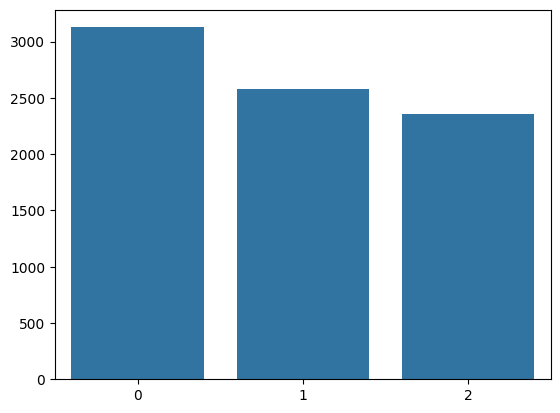

In [33]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['0','1','2']),y=dd.values)
plt.show()

Tockenization

In [34]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [35]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8064,) + inhomogeneous part.

In [69]:
# Contoh definisi model RNN sederhana
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Mengambil output dari step terakhir
        return out

In [70]:
input_size = 100  # Misalnya, ukuran vektor kata setelah tokenisasi
hidden_size = 128
output_size = 3  # Misalnya, 3 kelas sentimen (negatif, netral, positif)

model = RNNModel(input_size, hidden_size, output_size)

# Definisikan loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
train_loader

In [72]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs = batch['text']  # Ambil judul atau fitur yang relevan
        labels = batch['label']  # Ambil label sentimen yang telah diencode
        
        # Lakukan tokenisasi dan encoding di sini jika diperlukan
        
        # Contoh: Ubah input menjadi tensor PyTorch
        inputs_tensor = torch.Tensor(inputs)  # Sesuaikan dengan tokenisasi Anda
        labels_tensor = torch.Tensor(labels)  # Sesuaikan dengan encoding Anda
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs_tensor)
        
        # Hitung loss
        loss = criterion(outputs, labels_tensor)
        
        # Backward pass dan optimasi
        loss.backward()
        optimizer.step()
        # Evaluasi model di setiap epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['title']
            labels = batch['decision']
            
            # Lakukan tokenisasi dan encoding di sini jika diperlukan
            
            inputs_tensor = torch.Tensor(inputs)  # Sesuaikan dengan tokenisasi Anda
            labels_tensor = torch.Tensor(labels)  # Sesuaikan dengan encoding Anda
            
            # Forward pass
            outputs = model(inputs_tensor)
            
            # Hitung loss
            loss = criterion(outputs, labels_tensor)
            val_loss += loss.item()
            
            # Hitung akurasi
            _, predicted = torch.max(outputs, 1)
            total += labels_tensor.size(0)
            correct += (predicted == labels_tensor).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader)
    epoch_accuracy = correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}')


TypeError: list indices must be integers or slices, not str